In [1]:
# Imports
import torch
from torch.distributions import Normal
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from tqdm import tqdm
from torchvision.utils import save_image

In [2]:
images, ground_truth = torch.load('MNIST/processed/training.pt')

In [3]:
print(images.shape)
print(ground_truth.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


In [4]:
print(torch.min(images[0]))
print(torch.max(images[0]))

tensor(0, dtype=torch.uint8)
tensor(255, dtype=torch.uint8)


In [5]:
images[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

tensor(3)


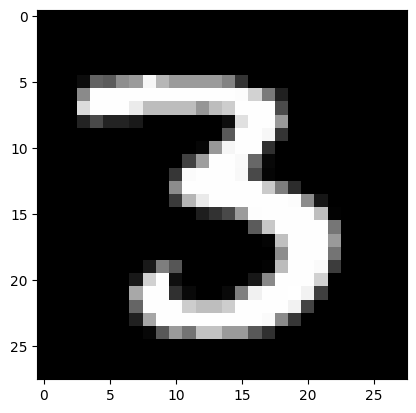

In [6]:
image_index = 12
print(ground_truth[image_index])
plt.imshow(images[image_index], cmap='gray')

In [7]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, path):
        self.images, self.ground_truth = torch.load(path)
        
    def __getitem__(self, idx):
        """
        Returns image with index idx
        """
        x = self.images[idx].float()
        x = torch.Tensor(x)
        x = torch.flatten(x) 
        return x
    
    def __len__(self):
        return len(self.ground_truth)

In [8]:
# make datasets
train_dataset = MNISTDataset('MNIST/processed/training.pt')
test_dataset = MNISTDataset('MNIST/processed/test.pt')

print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [11]:
train_dataset[15].shape
# train_dataset[15]

torch.Size([784])

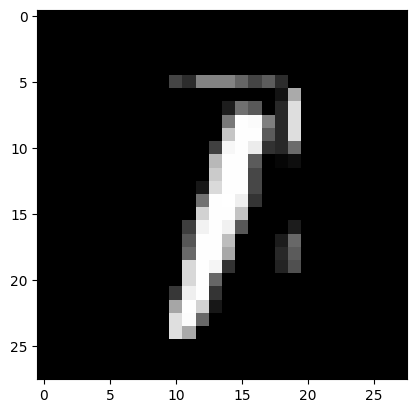

In [20]:
plt.imshow(train_dataset[67].numpy().reshape((28,28)), cmap='gray')


### AutoEncoder
$MSE =  \frac{1}{N} \sum_{i=1}^{n}(X_i - \hat{X}_i)^2$

Architecture:

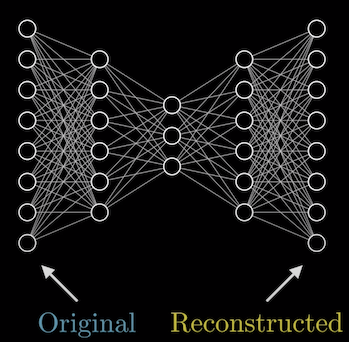

In [ ]:
import torch.nn as nn 

class AutoEncoder(nn.Module):
    def __init__(self, input_shape, latent_dim=128):
        super().__init__()
    
        # two fully connected layers for encoder (input_shape -> latent_dim)
        self.encoder_l1 = nn.Linear(in_features=input_shape, out_features=latent_dim)
        self.encoder_l2 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        
        # two fully connected layers for decoder (128 -> input_shape)
        self.decoder_l1 = nn.Linear(in_features=latent_dim, out_features=latent_dim)
        self.decoder_l2 = nn.Linear(in_features=latent_dim, out_features=input_shape)
        
    def forward(self, x):
        latent = self.run_encoder(x)
        x_hat = self.run_decoder(latent)
        
    def run_encoder(self,x):
        output = F.relu(self.conder_l1(x))
        latent = F.relu(self.encoder_l2(output)) 
        return latent # latent representation
    
    def run_decoder(self,latent):
        output = F.relu(self.decoder_l1(latent))
        x_hat = F.relu(self.decoder_l2(output))
        return x_hat # reconstructed images
    
